In [1]:
# based on MoAC project by Michał Sadowski

In [2]:
import os, sys
if 'google.colab' in sys.modules:
    %cd /content
    if not os.path.isdir('MPyDATA'):
        !git clone --depth 1 https://github.com/atmos-cloud-sim-uj/MPyDATA.git
    %cd MPyDATA
    !pip install -r requirements.txt

In [3]:
import os, sys
if 'google.colab' in sys.modules:
    %cd /content/MPyDATA/MPyDATA_examples/Williamson_and_Rasch_1989_as_in_Jaruga_et_al_2015_Fig_14
sys.path.insert(0, os.path.join(os.getcwd(), '../..'))

In [4]:
import numpy as np
import numba
import matplotlib.pyplot as plt
import matplotlib
from MPyDATA import VectorField, ScalarField
from MPyDATA import Options
from MPyDATA.arakawa_c.discretisation import from_pdf_2d
from MPyDATA import PeriodicBoundaryCondition, PolarBoundaryCondition
from MPyDATA import Stepper, Solver

In [5]:
options = Options(n_iters=1)

In [6]:
nlon = 64
nlat = 32
nt = 100
dlmb = 2 * np.pi / nlon
dphi = np.pi / nlat

r = 7/64 * np.pi
x0 = 3 * np.pi / 2
y0 = 0

udt = 2 * np.pi / nt
b = -np.pi / 2
h0 = 1

In [7]:
boundary_conditions = (PeriodicBoundaryCondition(), PolarBoundaryCondition((nlon, nlat), 0, 1))

In [8]:
@numba.njit()
def pdf(i, j):
    tmp = 2*(
        (np.cos(dphi * (j + 0.5) - np.pi / 2) * np.sin((dlmb * (i+.5) - x0) / 2))**2 +
        np.sin((dphi * (j + 0.5) - np.pi / 2 - y0) / 2)**2
    )
    return h0 + np.where(
        # if
        tmp - r**2 <= 0,
        # then
        1 - np.sqrt(tmp)/r,
        # else
        0.
    )

In [9]:
def ad_x(i, j):
    return dlmb * udt * (
        np.cos(b) * np.cos(j * dphi - np.pi / 2) + 
        np.sin(b) * np.sin(j * dphi - np.pi / 2) * np.cos((i+.5) * dlmb)
    )

In [10]:
def ad_y(i, j):
    return -dlmb * udt * np.sin(b) * np.sin(i * dlmb)* np.cos((j+.5) * dphi - np.pi / 2)

In [11]:
advector_x = np.array([[
    ad_x(i, j)
    for j in range(nlat)] for i in range(nlon+1)])

advector_y = np.array([[
    ad_y(i, j)
    for j in range(nlat+1)] for i in range(nlon)])

-0.0061610725189691394 0.0061610725189691394


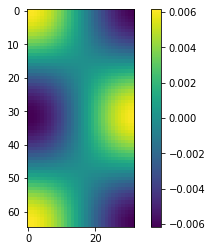

In [12]:
plt.imshow(advector_x)
plt.colorbar()
print(np.amin(advector_x), np.amax(advector_x))
np.testing.assert_array_almost_equal(advector_x[0,:], advector_x[-1,:])

-0.0061610725189691394 0.0061610725189691394


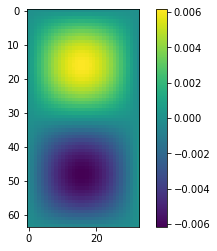

In [13]:
plt.imshow(advector_y)
plt.colorbar()
print(np.amin(advector_y), np.amax(advector_y))
np.testing.assert_array_almost_equal(advector_y[:,0], - advector_y[:,-1])

In [14]:
advector = VectorField(
    data=(advector_x, advector_y),
    halo=options.n_halo,
    boundary_conditions=boundary_conditions    
)

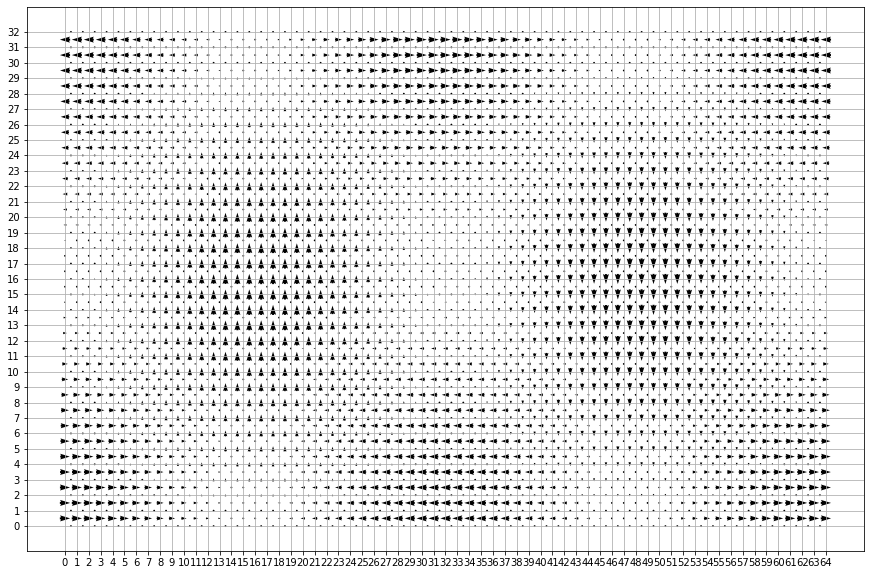

In [15]:
dx = 1
dy = 1
nx = nlon
ny = nlat

ux, uy = np.mgrid[
    0 : (nx+1)*dx : dx,
    dy/2 : ny*dy : dy
]

vx, vy = np.mgrid[
    dx/2 : nx*dx : dx,
    0: (ny+1)*dy : dy
]

fig = plt.figure(figsize=(15,10))
plt.xticks(ux[:,0])
plt.yticks(vy[0,:])
plt.grid()
plt.quiver(ux, uy, advector.get_component(0), 0, pivot='mid', scale=.5)
plt.quiver(vx, vy, 0, advector.get_component(1), pivot='mid', scale=.5)

In [16]:
@numba.njit()
def pdf_g_factor(x, y):
    return dlmb * dphi * np.cos(dphi * (y + 0.5) - np.pi / 2)
g_factor_z = np.array([[
    pdf_g_factor(i, j)
    for j in range(nlat)] for i in range(nlon)])

0.00047292825634092094


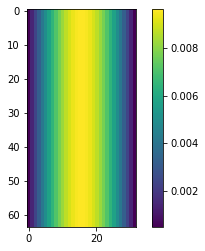

In [17]:
plt.imshow(g_factor_z)
plt.colorbar()
print(np.amin(np.abs(g_factor_z)))

In [18]:
g_factor = ScalarField(
    data=g_factor_z, 
    halo=options.n_halo, 
    boundary_conditions=boundary_conditions
)

In [19]:
x, y, z = from_pdf_2d(pdf, xrange=(0, nlon), yrange=(0, nlat), gridsize=(nlon, nlat))

advectee = ScalarField(
    data=z, 
    halo=options.n_halo, 
    boundary_conditions=boundary_conditions
)

In [20]:
stepper = Stepper(options=options, n_dims=2, non_unit_g_factor=True, n_threads=1) # TODO !!!!

In [21]:
solver = Solver(stepper=stepper, advectee=advectee, advector=advector, g_factor=g_factor)

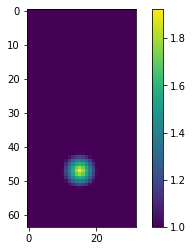

In [22]:
plt.imshow(solver.advectee.get())
plt.colorbar()

In [23]:
states_history = [z]
for i in range(15):
    solver.advance(nt=1)
    states_history.append(solver.advectee.get().copy())    

# Plots 

In [24]:
from matplotlib import cm
import matplotlib.animation as animation

theta = np.linspace(0, 1, nlat+1, endpoint=True) * np.pi
phi   = np.linspace(0, 1, nlon+1, endpoint=True) * 2 * np.pi

X = np.outer(np.sin(theta), np.cos(phi))
Y = np.outer(np.sin(theta), np.sin(phi))
Z = np.outer(np.cos(theta), np.ones(nlon+1))

def plot_state(state, save_path=None):
    fig = plt.figure(figsize=(15,10))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_axis_off()
    norm = matplotlib.colors.Normalize(vmin=h0, vmax=h0+1)
    ax.plot_surface(X, Y, Z, rstride=1, cstride=1, 
                    facecolors=cm.plasma(norm(state.T)), alpha=0.666, linewidth=.5)
    m = cm.ScalarMappable(cmap=cm.plasma, norm=norm)
    m.set_array([])
    plt.colorbar(m)
    if save_path:
        plt.savefig(save_path)
    return plt.show()

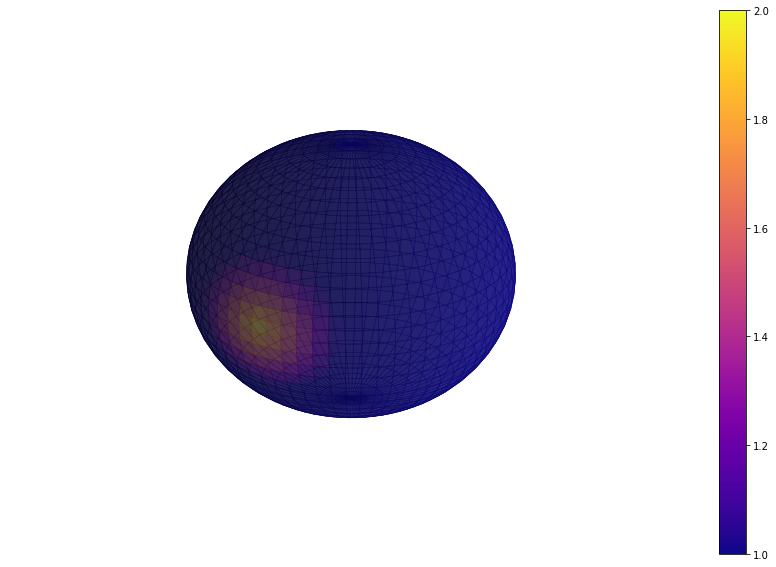

1.0 1.9227207239938844


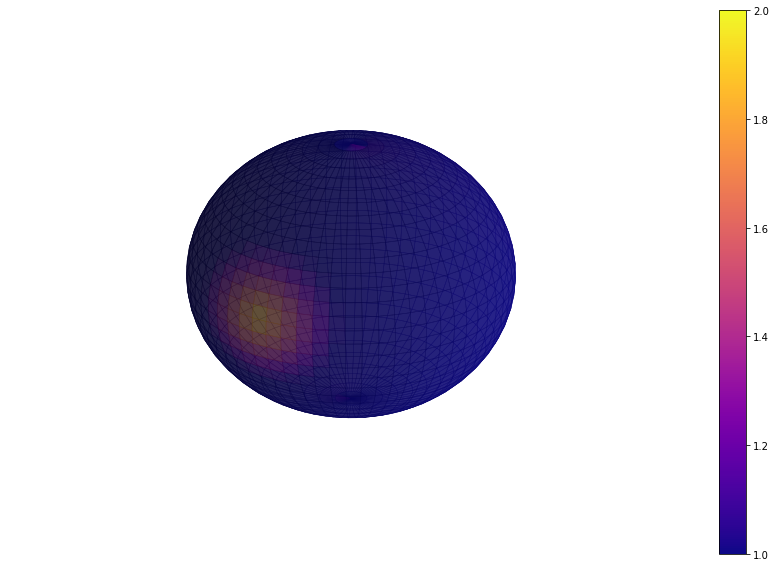

0.34782101040311075 1.8640475724678882


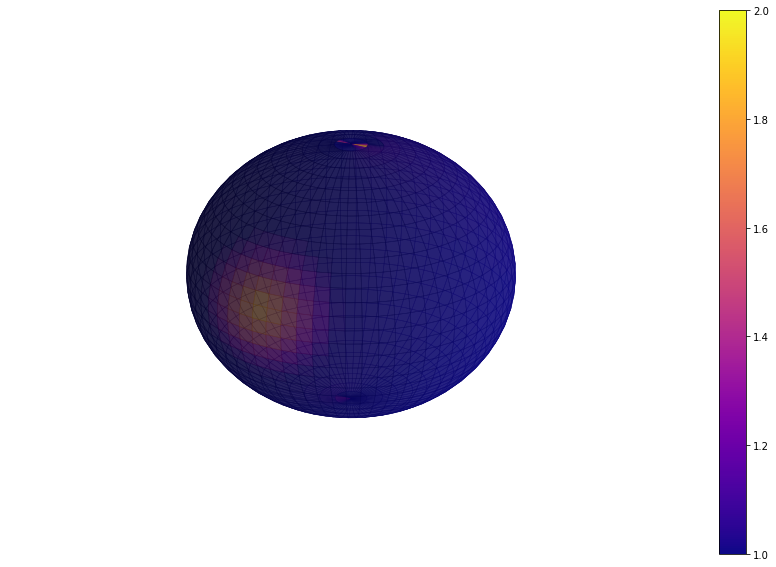

-0.09801122141631473 1.9452652845571579


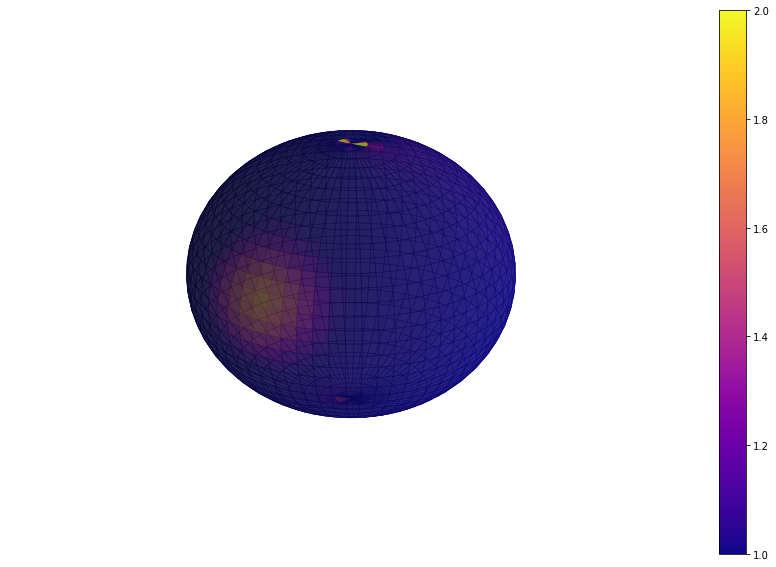

-9.553997818597448 3.5729677198032195


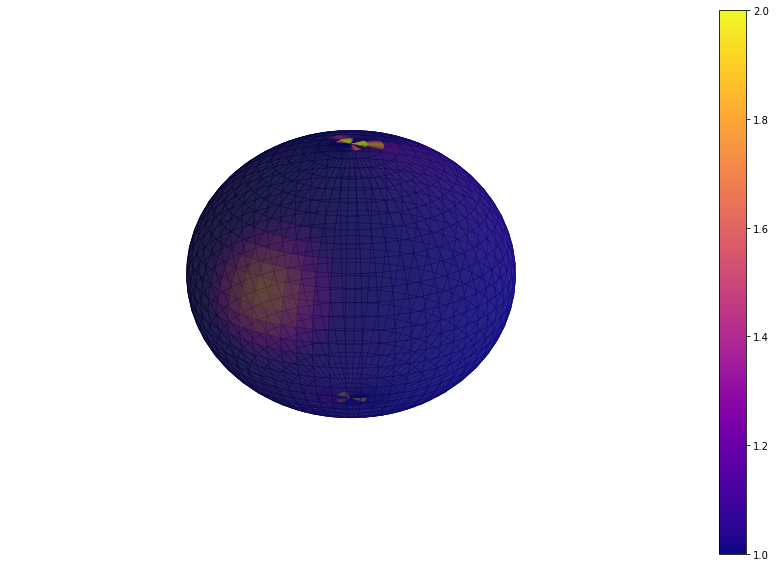

-134.17517846644574 110.42076247231918


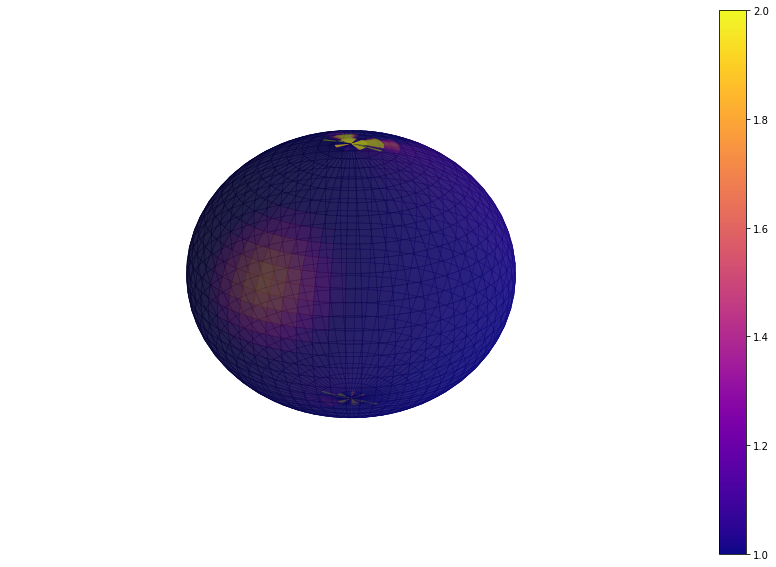

-1769.25094534209 3083.8014143965224


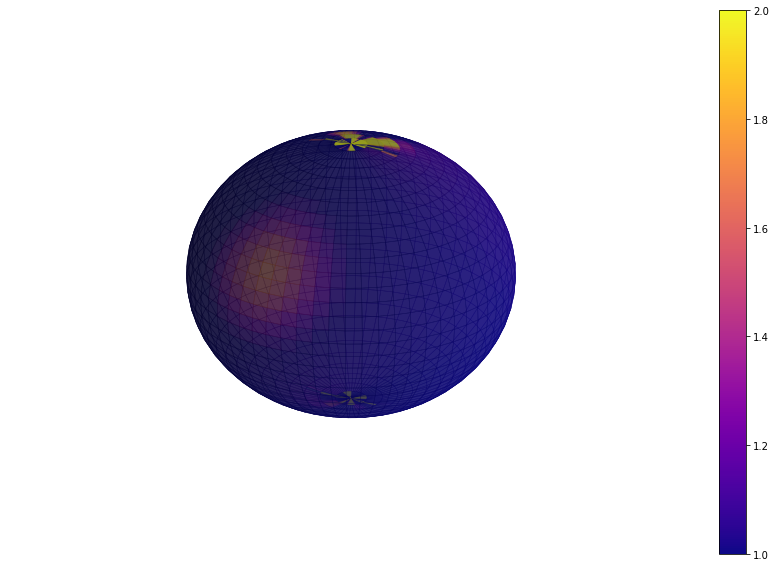

-55168.41385893227 61386.122680360146


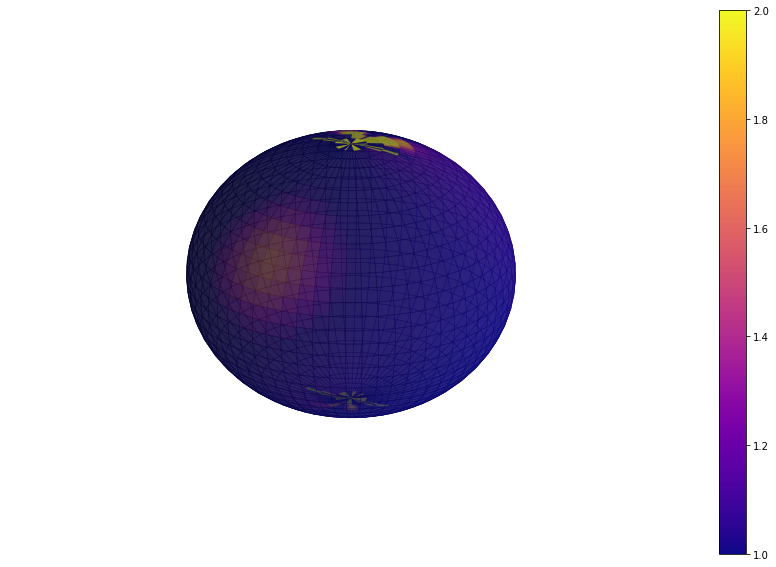

-1461179.3012165697 1045933.2674606808


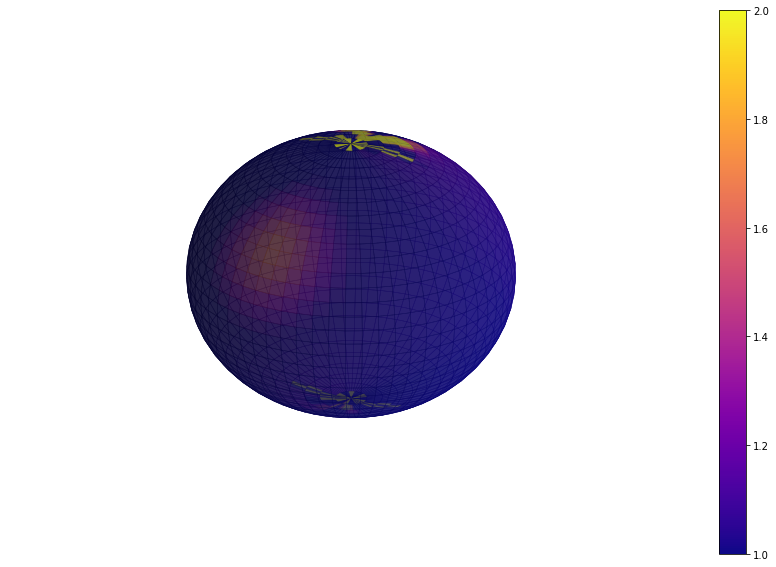

-31052264.73530992 29296700.90094742


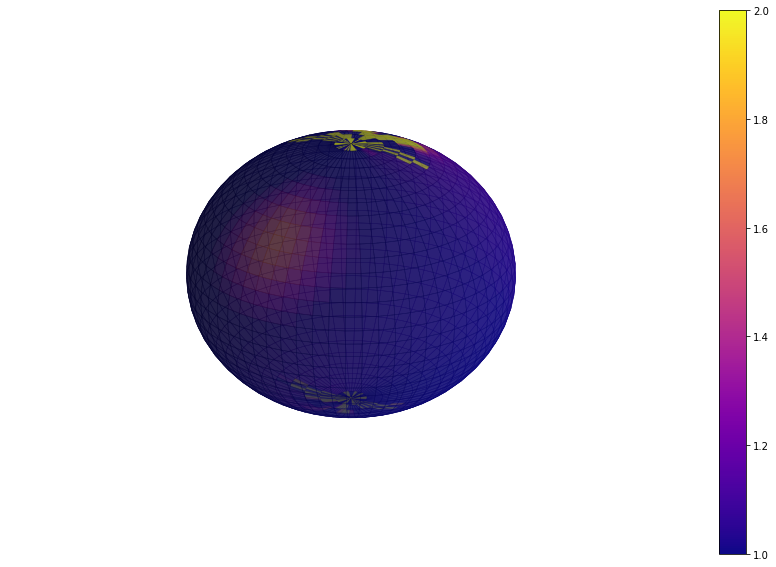

-569184744.7824023 743706825.6562593


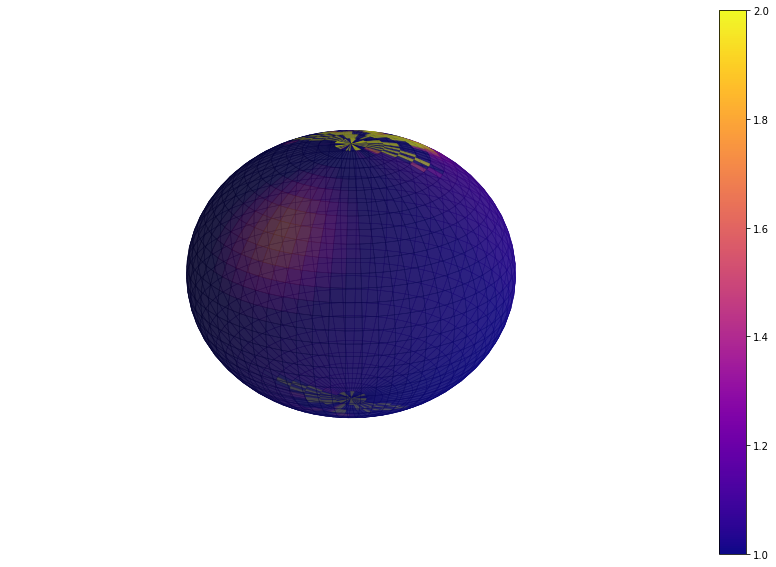

-15659715914.88569 15788816518.160719


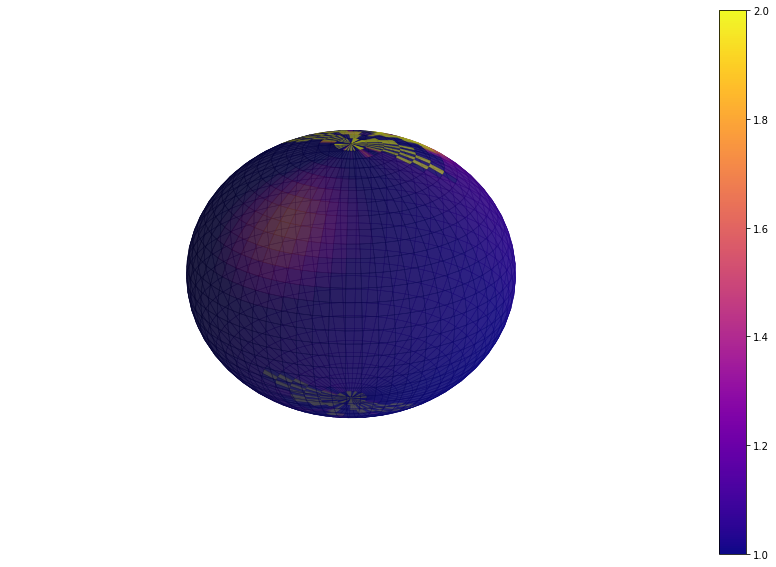

-376933362749.92645 302377880918.74664


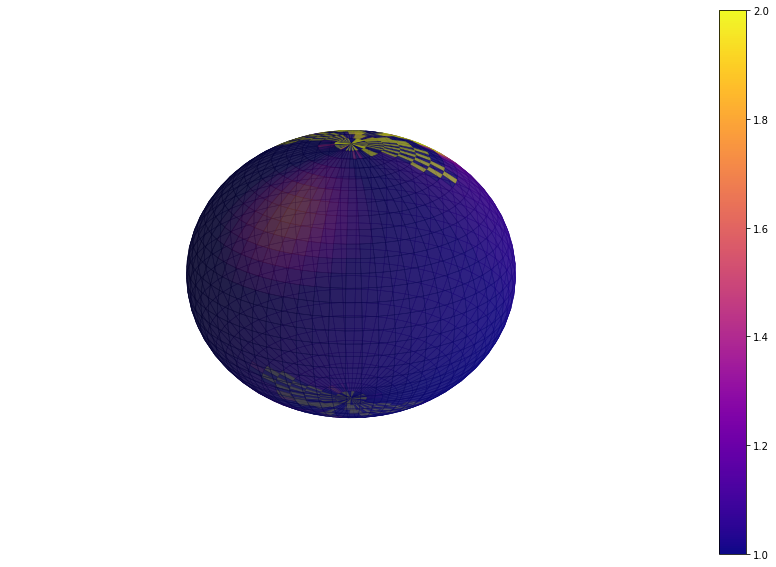

-7710172475121.585 8120948434586.241


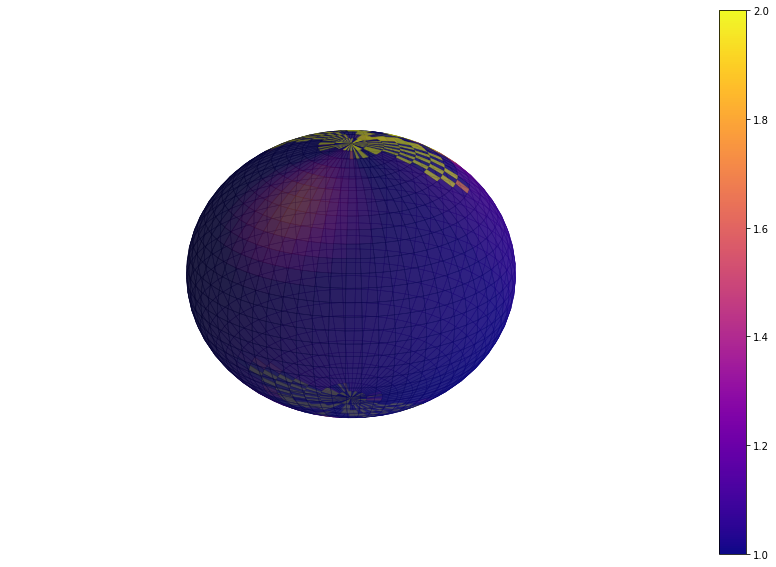

-162316802814312.9 182499123256634.0


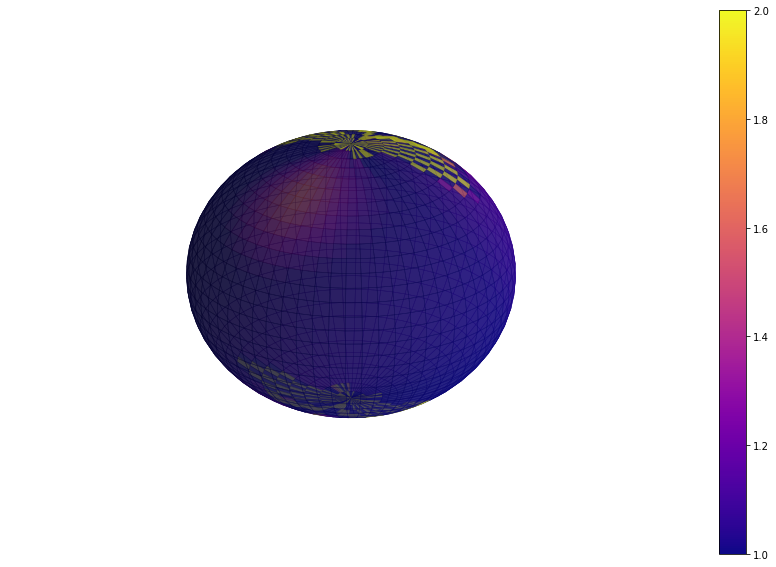

-3967126951066715.0 3499564778957508.0


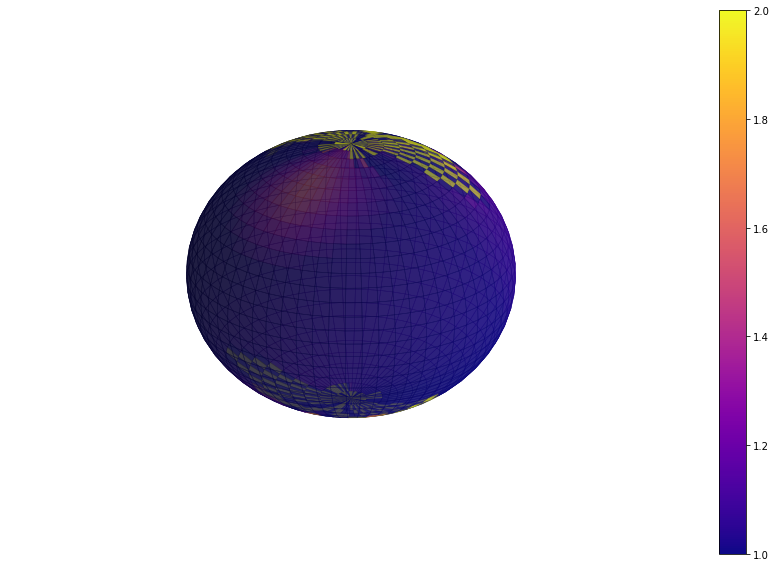

-8.179457213998182e+16 8.075199924885952e+16


In [25]:
!rm -rf animation
!mkdir animation
paths = []
for i, state in enumerate(states_history):
    path = 'animation/{}.png'.format(i)
    paths.append(path)
    plot_state(state, path)
    print(np.amin(state), np.amax(state))

In [26]:
import os
os.system("ffmpeg -f image2 -r 10 -i ./animation/%01d.png -vcodec mpeg4 -y simulation.mp4")

0

In [27]:
from IPython.display import Video
Video("simulation.mp4")